# Predict and evaluate SkillsColBERT

In [25]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow
#!pip install -U sentence-transformers
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

## Questions:

    a) Dimensions of max function in MaxSim method function.
        - max of column vectors in matrix OR max of row vectors in columns --> 24 dimensional
    b) Training of my ColBERT model
        - [Q] and [D] in vocabulary --> Drop
        - Weights in additional linear layer of 32
        - [MASK] as padding instead of [PAD]
    c) How to save:
        The model (in github) --> Drop
        The document embeddings
        


In [3]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [65]:
# specify CPU or GPU as device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(f'device = {device}')

device = cpu


In [2]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
model.to(device)

[[-0.2699744   0.08224882  1.4262305  ... -0.43902254 -1.2129796
   0.06791188]
 [ 0.44954592  0.34814388  1.2075768  ...  0.16226201  0.3187591
   0.18042587]]


In [4]:
# Load data
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


In [80]:
q_outputs = torch.tensor(model.encode(df['query'])).to(device)
torch.save(q_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')


In [66]:
# Make query embeddings or load them
#q_outputs = torch.tensor(model.encode(df['query'])).to(device)
q_outputs = torch.load(r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')
print(q_outputs.shape)

# Make document embeddings or load them
#d_outputs = torch.tensor(model.encode(df['documents'])).to(device)
d_outputs = torch.load(r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_doc_embeddings_tensor.pt')
print(d_outputs.shape)

#torch.save(q_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_query_embeddings_tensor.pt')
#torch.save(d_outputs, r'J:\VOA\MABI\Deep Learning\SkillsColBERT\xlm_embeddings\xlm_doc_embeddings_tensor.pt')

torch.Size([13485, 768])


In [81]:
def xlmMaxSim(q,D):
    mm = torch.matmul(q, torch.t(D))
    
    maks, maks_idx = torch.max(mm, dim=0) # dim=1 or dim=2

    return maks, maks_idx


# test agains 10 document
maks, maks_idx  = xlmMaxSim(q_outputs[0], d_outputs[:10])

print(maks.shape) # should be (batch_size, 24)
print(maks_idx)
    
#    # Sum over maximum values --> return vector of length len(D)
#    S_qD = torch.sum(maks, dim=1)

torch.Size([])
tensor(0)


# Import model
Queries and documents have now been tokenized to the vocabolary

In [ ]:
from transformers import BertConfig
from transformers import BertModel

model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
config = BertConfig.from_pretrained(model_path + r'\bert_config.json')
bert_base = BertModel(config)


class MyColBERT(nn.Module):
      def __init__(self):
            super(MyColBERT, self).__init__()
            self.bert = bert_base 
            ### New layers:
            self.linear1 = nn.Linear(768, 32) # 32 is "low" for faster computation of MaxSim (it is independent of sequence lentgh)

            # Freeze parameters of BERT Base as I only will train last layer
            for param in self.bert.parameters():
                  param.requires_grad = False
          

      def forward(self, q_ids, q_mask, d_ids, d_mask, q_index):
            query_embeddings, pooled_output = self.bert(q_ids[q_index:q_index+1], attention_mask=q_mask[q_index:q_index+1]) 
            query_embeddings = self.linear1(query_embeddings)
            query_embeddings = F.softmax(query_embeddings, dim=1)

            
            doc_embeddings, pooled_output = self.bert(d_ids, attention_mask=d_mask) # sequence_output shape is: (batch_size, sequence_length, 768)
            doc_embeddings = self.linear1(doc_embeddings)
            doc_embeddings = F.softmax(doc_embeddings, dim=1)

            # Compute score for a query against all documents (in batch) 
            score = F.softmax(self.MaxSim(query_embeddings[q_index], doc_embeddings), dim=0)

            return score

      
      def MaxSim(self, q, D):
            '''Takes in the embeddings of a query, q, and all documents' embeddings, D.
                Return a tensor of the query's similarity scores to all documents in D.'''

            # repeat q for faster matrix multiplication (faster than loop)
            batch_size=D.shape[0]
            q_X = q.repeat(batch_size, 1, 1)

            # multiply the same query q against all documents (in D)
            batch_mm = torch.bmm(q_X, D.permute(0,2,1))

            maks, maks_id = torch.max(batch_mm, dim=2) # should be (batch_size, 24)

            # Sum over maximum values --> return vector of length len(D)
            S_qD = torch.sum(maks, dim=1)

            # Most similar document number 
            #S_qD_max, most_similar_doc_id = torch.max(S_qD, dim=0)

            return S_qD
                  

## Load Query and Document embeddings

In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. 

In my implementation of BERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 768] \\
    dim(E_d) = [ 128 \times 768]
\end{align*}

but with ColBert the last dimension is reduced to 32 by an additional linear layer, such that my implementation of ColBERT, the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_d) = [ 128 \times 32]
\end{align*}

In practice the MaxSim score is implemented such that 1 query is evaluated against all ducuments. Therefore the relevant dimensions are:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_D) = [13.485 \times 128 \times 32]
\end{align*}
where 32 is 768 if standard BERT embeddings are used.


### The relevancy score, MaxSim, is defined as follows:
$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

In [99]:
def MinEuc(q, D):
    '''Takes in the embeddings of a query, q, and all documents' embeddings, D.
        Return a tensor of the query's similarity scores to all documents in D.'''
    
    # Euclidean distance between query q against all documents (in D)
    EucDist = torch.cdist(q, D, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')
    
    mini, _ = torch.min(EucDist, dim=1) # dim=1 or dim=2
    #print(mini.shape) # should be (batch_size, 24)
    
    # Sum over minimum values --> return vector of length len(D)
    #S_qD = torch.sum(mini, dim=1)
    
    return S_qD

## MaxSim implementation

In [78]:
q_outputs.shape

torch.Size([10, 768])

In [87]:
# set sample size, i.e. number of queries to calculate MaxSim score
sample_size = q_outputs.shape[0] # 100

most_similar_doc_score = []
most_similar_docID = []

 # Define D as all documents:
D = d_outputs[:sample_size]

for q_no in tqdm(range(sample_size)):
    
    # Select one query
    q = q_outputs[q_no]

    # Compute similarity scores for all 
    #S_qD = MaxSim(q, D)
    mm = torch.matmul(q, torch.t(D))
    
    maks, maks_id = torch.max(mm, dim=0) 

    most_similar_doc_score.append(float(maks))
    most_similar_docID.append(int(maks_id))

100%|██████████| 13485/13485 [01:05<00:00, 205.58it/s]


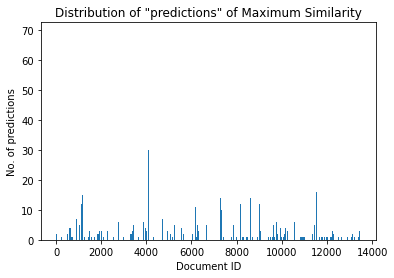

In [88]:
# Distribution of "predictions"
plt.hist(most_similar_docID, bins=D.shape[0])
plt.title('Distribution of "predictions" of Maximum Similarity')
plt.xlabel('Document ID')
plt.ylabel('No. of predictions')
plt.show()

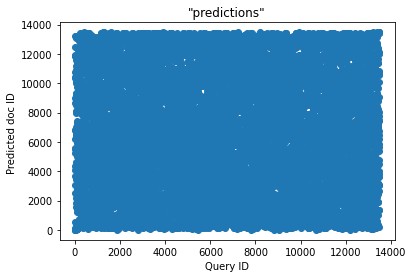

In [89]:
# Distribution of "predictions"
q_IDs = [x for x in range(sample_size)]
plt.scatter(q_IDs, most_similar_docID)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [90]:
from sklearn.metrics import f1_score
y_true = q_IDs
y_pred = most_similar_docID

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

f_1score:  0.1489


In [91]:
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

rights: 2792 out of 13485 
 0.207% accuracy


In [45]:
df_correct = df.iloc[:sample_size,:].loc[(np.array(y_true) == np.array(y_pred))]
df_correct

NameError: name 'df' is not defined

In [81]:
# Inspect specific document. - Why are 49 and 79 getting this many hits. 
df.documents[79]

'Overvåge og vedligeholde boringsvæskerne eller "mudder". Tilføje forskellige kemikalier til væsken med henblik på at udføre forskellige funktioner i brøndoperationer: holde borebitten afkølet, hydrostatisk tryk, osv.'

## Example of implementation of MINIMUM Eucledian distance

In [98]:
EucDist = torch.cdist(q_outputs, d_outputs, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')
EucDist.shape
mini, mini_ids = torch.min(EucDist, dim=0)
mini_ids.shape

tensor([ 8821,  9800,   157, 12585, 12366,     5,  5168,  7654,  6466, 13088])

In [ ]:
# set sample size, i.e. number of queries to calculate MaxSim score
#sample_size = 100# q_outputs.shape[0] # 100
#
#most_similar_doc_score = []
#most_similar_docID = []
#
# # Define D as all documents:
#D = d_outputs[:sample_size]

#for q_no in tqdm(range(sample_size)):
#    
#    # Select one query
#    q = q_outputs#[q_no]
#
#    # Compute similarity scores for all 
#    #S_qD = MaxSim(q, D)
#    S_qD = MinEuc(q, D)
#    mini, mini_id = torch.min(S_qD, dim=0)
#
#    most_similar_doc_score.append(float(mini))
#    most_similar_docID.append(int(mini_id))

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: cdist(): argument 'x1' (position 1) must be Tensor, not numpy.ndarray

In [100]:
# Distribution of "predictions"
plt.hist(mini_ids, bins=D.shape[0])
plt.title('Distribution of "predictions" of minimum Euclidean distance')
plt.xlabel('Document ID')
plt.ylabel('No. of predictions')
plt.show()

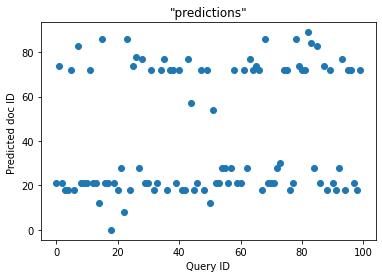

In [ ]:
# Distribution of "predictions"
q_IDs = [x for x in range(sample_size)]
plt.scatter(q_IDs, mini_ids)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
y_true = q_IDs
y_pred = mini_ids

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

f_1score:  0.0


In [ ]:
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

rights: 0 out of 100 
 0.0% accuracy


## Benchmark
BERCH embedding Euclidean distance